In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import os
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from PIL import Image
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
from sklearn.model_selection import train_test_split
import cv2

C:\Users\95kes\python\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\95kes\python\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\95kes\python\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [36]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


### Adding images and converting to numpy array

In [3]:
directory = os.path.join('dataset','training_shuffle_400')

In [38]:
def read_pil_image(img_path, height, width):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((width, height)))

def load_all_images(dataset_path, height, width, img_ext='png'):
    return np.array([read_pil_image(str(p), height, width) for p in 
                                    Path(dataset_path).rglob("*."+img_ext)]) 

In [39]:
train_datagen = ImageDataGenerator(rescale=1./255.,validation_split = .25)
test_datagen = ImageDataGenerator(rescale=1./255.)
train_datagen_std = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(zca_whitening=True)

In [40]:

x = load_all_images(os.path.join('dataset','small_train_sample'),64,64)

train_datagen.fit(x)
test_datagen.fit(x)

In [41]:
# train_datagen.fit(load_all_images(directory, 64, 64))
# test_datagen.fit(load_all_images(os.path.join('dataset','test_random'), 64, 64))
# test_datagen.fit(load_all_images(directory, 64, 64))
# train_datagen.fit(load_all_images(directory, 64, 64))

In [42]:
training_set = train_datagen.flow_from_directory(
    directory,target_size=(64, 64),batch_size=64,class_mode='categorical', shuffle = True,subset='training'
)

validation_set = train_datagen.flow_from_directory(directory,
                                        target_size=(64, 64),
                                                 batch_size=64,
                                      class_mode='categorical',
                                               shuffle = True,
                                           subset='validation')

test_set = test_datagen.flow_from_directory(os.path.join('dataset','test_random'),
                                                target_size=(64, 64),
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle = True)
# images_std = train_datagen_zca.flow_from_directory(
#     directory,target_size=(64, 64),batch_size=34,class_mode='categorical'
# )

# images_zca = train_datagen_zca.flow_from_directory(
#     directory,target_size=(64, 64),batch_size=34,class_mode='categorical'
# )

In [43]:
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = training_set.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image[0])
# show the figure
plt.show()

In [4]:
# def load_images(directory):
#     images = []
#     labels = []
#     for idx, label in enumerate(uniq_labels):
#         for file in os.listdir(directory + "/" + label):
#             filepath = directory + "/" + label + "/" + file
#             # image = cv2.resize(cv2.imread(filepath), (64, 64))
#             images.append(image)
#             labels.append(idx)
#     images = np.array(images)
#     labels = np.array(labels)
#     return(images, labels)

# uniq_labels = sorted(os.listdir(directory))
# images, labels = load_images(directory = directory)
# test_images,test_lables = load_images(directory = os.path.join('dataset','test_random'))

In [47]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels)

In [51]:

# Model architechture
model = Sequential()
# The first two layers with 32 filters of window size 3x3
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(24, activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        36928     
                                                      

In [52]:
patience = 1
stop_patience = 4
factor = 0.5
# checkpoint_path = "training_1_test/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1, restore_best_weights=True),
    # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1),
    # tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
    #                                              save_weights_only=True,
    #                                              verbose=1)
]


In [53]:
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6)
model.compile('adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [54]:
history = model.fit(training_set,epochs=30,validation_data = validation_set,verbose=1,callbacks=callbacks)

Epoch 1/30
97/97 [==============================] - 3s 25ms/step - loss: 3.5801 - accuracy: 0.1718 - val_loss: 8.3334 - val_accuracy: 0.0272
Epoch 2/30
97/97 [==============================] - 3s 29ms/step - loss: 1.5572 - accuracy: 0.5091 - val_loss: 12.0952 - val_accuracy: 0.0705
Epoch 3/30
97/97 [==============================] - 3s 28ms/step - loss: 1.0130 - accuracy: 0.6885 - val_loss: 12.8544 - val_accuracy: 0.1164
Epoch 4/30
97/97 [==============================] - 3s 28ms/step - loss: 0.7340 - accuracy: 0.7686 - val_loss: 11.1191 - val_accuracy: 0.1371
Epoch 5/30
97/97 [==============================] - 3s 28ms/step - loss: 0.5585 - accuracy: 0.8256 - val_loss: 13.1443 - val_accuracy: 0.1210
Epoch 6/30
97/97 [==============================] - 3s 28ms/step - loss: 0.4656 - accuracy: 0.8481 - val_loss: 14.9378 - val_accuracy: 0.1158
Epoch 7/30
97/97 [==============================] - 3s 28ms/step - loss: 0.3685 - accuracy: 0.8803 - val_loss: 16.8695 - val_accuracy: 0.1371
Epoch 8

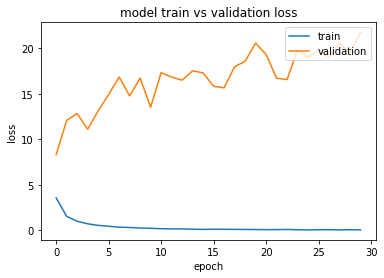

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

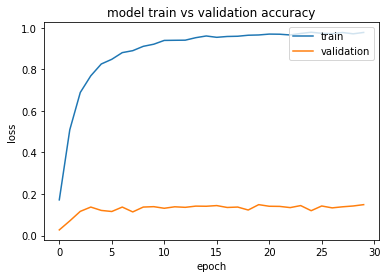

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [57]:
model.evaluate(test_set)

8/8 [==============================] - 0s 5ms/step - loss: 5.1687 - accuracy: 0.6208


[5.168748378753662, 0.6208333373069763]

In [58]:
# from sklearn.metrics import accuracy_score
yhat = model.predict(test_set)
yhat = yhat.round()
# acc = accuracy_score(y_test,yhat)
# acc

0.6166666666666667

In [61]:
labelsPred = np.argmax(yhat, axis=-1)  
labelsPred

array([ 0,  0,  0,  0, 18,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3, 12,
        3, 16,  3,  3,  3,  3, 17, 17, 17,  0, 12, 17, 17, 17, 17, 17,  5,
        5,  0,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6, 15,
        6,  6,  7,  6,  7,  7,  7,  6,  6,  6,  6,  7,  8,  8,  0,  8,  8,
        8, 17,  8,  8,  8,  9,  9,  9,  7,  0,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 18, 18, 18, 18, 12, 18, 18, 18, 12, 12, 13, 13, 13, 17, 13, 13,
       17, 13, 13, 13,  0, 14,  0,  0, 18, 14, 14,  0, 14, 14, 15,  4, 14,
       13,  0, 13,  0, 18,  0, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17,  0, 18, 18, 15, 18,  0,  0,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19,  0, 19, 19, 16, 19,
       19, 19, 19, 16, 16, 19,  1,  0,  1,  3,  3,  1,  1,  1,  3, 16,  3,
        2,  9,  0,  0, 17